训练自编码器

欧卡姆提剃刀做消融实验

MLP + 卷积
---

训练结果：

训练误差最小：0.00226045330055058



In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T7PIAE3
import numpy as np

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/data/Task1_data'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_data.kpl'))
val_data = load_preprocessed_data(os.path.join(input_file,'val_data.kpl'))
dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[2],tarin_data[3])

dataloader = DataLoader(dataset, batch_size=600, shuffle=True)

val_feat = val_data[0].to(device)
val_edagepoint = val_data[1].to(device)
val_endstate = val_data[2].to(device)
val_label = val_data[3].to(device)

In [3]:

# 3. 定义模型、损失函数和优化器
#模型
model = T7PIAE3(torch.tensor(10),torch.tensor(0.25))

# 损失函数
criterion = nn.MSELoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.to(device)


T7PIAE3(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=38, out_features=800, bias=True)
    (2): ReLU()
    (3): Linear(in_features=800, out_features=400, bias=True)
    (4): ReLU()
  )
  (encoder_ax): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=220, bias=True)
    (3): Unflatten(dim=1, unflattened_size=(10, 22))
    (4): Conv1d(10, 10, kernel_size=(3,), stride=(1,))
    (5): ReLU()
    (6): Conv1d(10, 1, kernel_size=(3,), stride=(1,))
    (7): Tanh()
  )
  (encoder_delta): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=220, bias=True)
    (3): Unflatten(dim=1, unflattened_size=(10, 22))
    (4): Conv1d(10, 10, kernel_size=(3,), stride=(1,))
    (5): ReLU()
    (6): Conv1d(10, 1, kernel_size=(3,), stride=(1,))
    (7): Tanh()
  )
)

In [4]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/logs/log3')


# 4. 训练模型Autoencoder
epochs = 600

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (feat,edagepoint,endstate,label) in enumerate(dataloader):  
        
        label = label.to(device)  # 将输入数据移动到同一设备
        feat = feat.to(device)
        edagepoint = edagepoint.to(device)
        endstate = endstate.to(device)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task4_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task3_model_best.pth')
        best_loss = val_loss.item()


    print(f'\rEpoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()} ')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


Epoch 1, Train Loss: 0.04611849784851074, Val Loss: 0.037781719118356705 
Epoch 2, Train Loss: 0.012758322060108185, Val Loss: 0.011685378849506378 
Epoch 3, Train Loss: 0.00927432719618082, Val Loss: 0.009277346543967724 
Epoch 4, Train Loss: 0.012501888908445835, Val Loss: 0.013769546523690224 
Epoch 5, Train Loss: 0.00451821880415082, Val Loss: 0.007760315202176571 
Epoch 6, Train Loss: 0.010043932124972343, Val Loss: 0.006561553571373224 
Epoch 7, Train Loss: 0.004086958710104227, Val Loss: 0.005626981612294912 
Epoch 8, Train Loss: 0.020186876878142357, Val Loss: 0.005759599152952433 
Epoch 9, Train Loss: 0.005526956170797348, Val Loss: 0.005135027226060629 
Epoch 10, Train Loss: 0.005711621139198542, Val Loss: 0.00513087585568428 
Epoch 11, Train Loss: 0.0023200998548418283, Val Loss: 0.004570809192955494 
Epoch 12, Train Loss: 0.0031090080738067627, Val Loss: 0.0053416150622069836 
Epoch 13, Train Loss: 0.0054403613321483135, Val Loss: 0.006748205982148647 
Epoch 14, Train Loss:

In [5]:


model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task3_model_best.pth', weights_only=True))

with torch.no_grad():
    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    print('\r重构误差：',val_loss.item())



重构误差： 0.00226045330055058


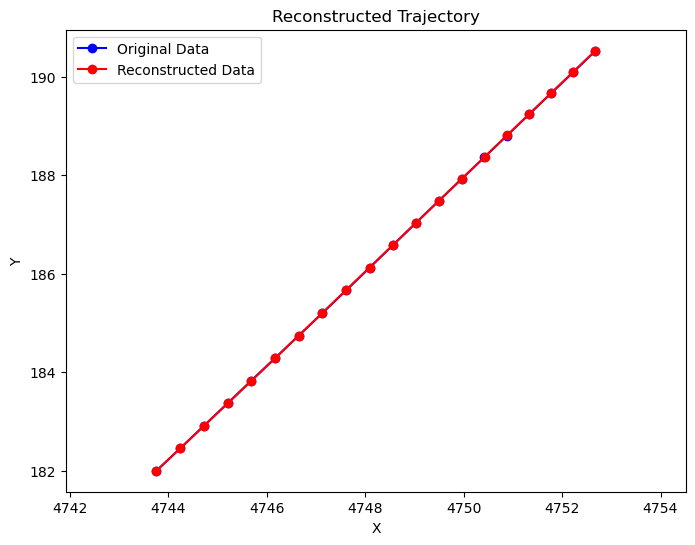

In [6]:
plt.figure(figsize=(8, 6))
# 绘制原始轨迹

# num = 845
num = np.random.randint(0,30000)
# num = 0
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='Original Data')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '-o', c='red', label='Reconstructed Data')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()